In [1]:
import jupyter

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker



In [3]:
# Configuration ======================
excluded_tickers = sorted(['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV'])

config = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0
}

run_settings = {
    "excluded_tickers": excluded_tickers,
    "min_samples": 10,
    "cv_folds": 3,
    "lags": 5,
    "start_date": "2023-12-31",
    "end_date": "2025-05-01",
    "seed": 314,
    "episode_length": 50,
    "noise_feature_cols": ["return_1d", "volume"],
    "train_steps": 50_000,
    "lookback": 0,
    
}

# System Boot =======================
DEVICE = boot()



In [4]:
# Helper functions ====================
import numpy as np

def compute_returns_curve(curve):
    returns = np.diff(curve) / curve[:-1]
    return returns

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess = returns - risk_free_rate
    return np.mean(excess) / (np.std(excess) + 1e-8)

def sortino_ratio(returns, risk_free_rate=0.0):
    returns = np.array(returns)
    excess = returns - risk_free_rate
    downside = excess[excess < 0]
    
    # Avoid division by zero: if no downside, assume very small downside deviation
    if len(downside) == 0:
        downside_std = 1e-8
    else:
        downside_std = np.std(downside)
    
    return np.mean(excess) / downside_std


def calmar_ratio(returns_curve):
    total_return = returns_curve[-1] / returns_curve[0] - 1
    drawdown = np.maximum.accumulate(returns_curve) - returns_curve
    max_drawdown = np.max(drawdown) / returns_curve[0]
    return total_return / (max_drawdown + 1e-8)

def central_tendency_difference (mean,median,std):
    return abs(mean-median)/(abs(std))

In [51]:
import os
import json
import hashlib
from collections import defaultdict
STORAGE_PATH = "data/experiments/episode_benchmark_engine/runs.csv"


EXCLUDED_TICKERS = sorted(["CEG", "GEHC", "GEV", "KVUE", "SOLV"])

CONFIG = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0,
}
LOOKBACK = 0
EPISODE_LENGTH = 50

RUN_SETTINGS = {
    "excluded_tickers": EXCLUDED_TICKERS,
    "cv_folds": 3,
    "lags": 5,
    "seed": 314,
    'total_timesteps':50_000,
    "episode": {
        "episode_length": EPISODE_LENGTH,
        "lookback": LOOKBACK,
    },
    "environment": {
        "market_features": ["close", "price_change", "volume_change"],
        "version": "v2",
        "lookback": LOOKBACK,
        "episode_length": EPISODE_LENGTH,
        "transaction_cost": 0,
    },
    "agent": {
        "model_class": "PPO",
        "policy_class": "MlpPolicy",
        "config": {
            "verbose": 1,
            "ent_coef":0.1,
            "policy_kwargs": 
                {
                
                    "net_arch": [64, 64]
                    }
                },
    },
}


class EpisodeBenchmark:
    def __init__(
        self,
        tickers=["AAPL"],
        config=CONFIG,
        run_settings=RUN_SETTINGS,
        start_date="2024-01-01",
    ):
        self.ohlcv_df = OHLCV_DF.copy()
        self.tickers = tickers  # Force test with AAPL
        self.start_date = start_date


        self.config = CONFIG.copy()
        self.config.update(config)
        
        self.run_settings = RUN_SETTINGS.copy()
        self.run_settings.update(run_settings)
        self.run_settings['environment']['market_features'].sort()
        
        self.ep_tracker = EpisodeTracker()
        self.env_tracker = EnvironmentTracker()
        self.agent_tracker = AgentTracker()
        
        self.boot()
        
    def boot(self):
        if os.path.exists(STORAGE_PATH):
            self.completed_runs_df = pd.read_csv(STORAGE_PATH)

            self.completed_hashes = set(self.completed_runs_df["run_hash"].unique())
            self.seen_seeds = defaultdict(set)
            for _, row in self.completed_runs_df.iterrows():
                self.seen_seeds[row["run_hash"]].add(row["seed"])
        else:
            self.completed_runs_df = pd.DataFrame()
            self.completed_hashes = set()
            self.seen_seeds = defaultdict(set)

    def compute_run_hash(self, agent_id, train_episode_id,train_environment_id):
        market_features =self.run_settings['environment']['market_features']
        market_features.sort()
        payload = {
            "agent_id": agent_id,
            "episode_id": train_episode_id,
            "environment_id":train_environment_id,
            "timesteps": self.run_settings['total_timesteps'],
            "lookback":self.run_settings['episode']['lookback'],
            "episode_length":self.run_settings['episode']['episode_length'],
            "market_features":json.dumps(market_features)
        }
        return hashlib.md5(json.dumps(payload, sort_keys=True).encode()).hexdigest()
    
    def extract_agent_diagnostics(self,env, model, mode="train"):
        """
        Runs agent through environment and extracts residual diagnostics
        from reward trajectory, wallet progression, and optionally oracle and market.
        """
        rewards = []
        residuals_oracle = []
        obs = env.reset()[0]
        done = False

        oracle_progress = []
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)

            # Oracle fallback
            oracle_score = info.get("oracle_score", None)
            if oracle_score is not None:
                oracle_progress.append(oracle_score)
                residuals_oracle.append(oracle_score - reward)
            else:
                oracle_progress.append(abs(reward))

        # Agent vs Oracle residuals
        if residuals_oracle:
            r_oracle = np.array(residuals_oracle)
        else:
            smoothed = pd.Series(rewards).rolling(window=5, min_periods=1).mean()
            r_oracle = np.array(rewards) - smoothed.values

        # Agent vs Market residuals
        agent_returns = np.array(env.wallet_progress)
        market_returns = np.array(env.market_progress)
        r_market = agent_returns - market_returns

        # Daily returns
        returns = pd.Series(agent_returns).pct_change().dropna().values
        market_pct_returns = pd.Series(market_returns).pct_change().dropna().values

        diagnostics = {
            f"{mode}_total_reward": env.total_reward,
            f"{mode}_wallet":env.wallet,
            f"{mode}_market":env.market_progress[-1],

            # Residuals vs Oracle
            f"{mode}_resid_oracle_std": np.std(r_oracle),
            f"{mode}_resid_oracle_skew": skew(r_oracle),
            f"{mode}_resid_oracle_kurtosis": kurtosis(r_oracle),
            f"{mode}_resid_oracle_acf1": pd.Series(r_oracle).autocorr(lag=1),
            f"{mode}_resid_oracle_mean": np.mean(r_oracle),
            f"{mode}_resid_oracle_median": np.median(r_oracle),
            f"{mode}_resid_oracle_max": np.max(r_oracle),
            f"{mode}_resid_oracle_min": np.min(r_oracle),
            f"{mode}_ljung_oracle_pval": (
                acorr_ljungbox(r_oracle, lags=[min(10, len(r_oracle) - 1)], return_df=True).iloc[0]['lb_pvalue']
                if len(r_oracle) > 10 else np.nan
            ),

            # Residuals vs Market
            f"{mode}_resid_market_std": np.std(r_market),
            f"{mode}_resid_market_skew": skew(r_market),
            f"{mode}_resid_market_kurtosis": kurtosis(r_market),
            f"{mode}_resid_market_acf1": pd.Series(r_market).autocorr(lag=1),
            f"{mode}_resid_market_mean": np.mean(r_market),
            f"{mode}_resid_market_median": np.median(r_market),
            f"{mode}_resid_market_max": np.max(r_market),
            f"{mode}_resid_market_min": np.min(r_market),
            f"{mode}_ljung_market_pval": (
                acorr_ljungbox(r_market, lags=[min(10, len(r_market) - 1)], return_df=True).iloc[0]['lb_pvalue']
                if len(r_market) > 10 else np.nan
            ),

            # Financial performance
            f"{mode}_sharpe": sharpe_ratio(returns),
            f"{mode}_sortino": sortino_ratio(returns),
            f"{mode}_calmar": calmar_ratio(agent_returns),
            f"{mode}_market_sharpe": sharpe_ratio(market_pct_returns),
            f"{mode}_market_sortino": sortino_ratio(market_pct_returns),
            f"{mode}_market_calmar": calmar_ratio(market_returns),
        }

        return diagnostics


    def correlation_with_test_result(self,test_result_feature="test_total_reward"):
        pddf = self.completed_runs_df.copy()
        
        cols_to_drop = [col for col in pddf.columns if col.startswith('test_') and col != test_result_feature]
        pddf_cleaned = pddf.drop(columns=cols_to_drop)

        correlations = pddf_cleaned.corr(numeric_only=True)[test_result_feature].sort_values(ascending=False)
        
        return correlations
    
    def describe(self, feature =None):
        descriptions = {
            "resid_mean": 
                "Mean of the residuals between agent and oracle/market.\n"
                "- Ideal: Close to 0 (no bias).\n"
                "- Positive: agent tends to overperform the benchmark.\n"
                "- Negative: consistent underperformance.",

            "resid_std": 
                "Standard deviation of residuals (volatility of difference).\n"
                "- Ideal: Low (stable excess performance).\n"
                "- High: unstable or noisy relative performance.",

            "resid_acf1": 
                "Autocorrelation at lag 1 of residuals.\n"
                "- Ideal: Close to 0 (no pattern).\n"
                "- Positive: persistent patterns (possibly exploitable).\n"
                "- Negative: mean-reverting behavior.",

            "resid_min": 
                "Minimum residual — worst case vs benchmark.\n"
                "- Ideal: Not too negative.\n"
                "- Negative: large underperformance at some point.",

            "resid_max": 
                "Maximum residual — best case vs benchmark.\n"
                "- Ideal: High (agent strongly beats the benchmark).",

            "resid_skew": 
                "Skewness of residual distribution.\n"
                "- Ideal: Slightly positive (more upside extremes).\n"
                "- Negative: heavier downside risks.",

            "resid_kurtosis": 
                "Kurtosis of residuals — fat tails.\n"
                "- Ideal: Moderate (3 is normal).\n"
                "- High: rare but extreme performance differences.",

            "resid_ljung_pval": 
                "Ljung-Box test p-value for autocorrelation in residuals.\n"
                "- Ideal: > 0.05 (no significant autocorrelation).\n"
                "- Low: residuals have autocorrelation (potential inefficiency).",

            "sharpe": 
                "Sharpe ratio — risk-adjusted return.\n"
                "- Ideal: High (>1 good, >2 excellent).\n"
                "- Negative: losing money or volatile with low return.",

            "sortino": 
                "Sortino ratio — like Sharpe but penalizes only downside risk.\n"
                "- Ideal: High (>1).\n"
                "- More robust than Sharpe when upside is volatile.",

            "calmar": 
                "Calmar ratio — return / max drawdown.\n"
                "- Ideal: High (>1).\n"
                "- Penalizes deep losses more than volatility-based ratios.",
        }
        if feature !=None:
            print(descriptions.get(feature, "No description available for this feature."))
        else:
            for k,v in descriptions.items():
                print(v)
                print('')
                
    def run(self, tickers=None):
        # Configurations =============================
        config = self.config
        run_settings = self.run_settings

        # Feature Extraction Loop ====================
        features, targets, metadata, runs = [], [], [], []
        ohlcv_df = self.ohlcv_df.copy()

        if tickers == None:
            tickers = self.tickers
        
        seed = 314
        boot(seed)
        
        for symbol in tqdm(tickers):
            df = ohlcv_df[ohlcv_df["symbol"] == symbol].sort_values("date").copy()
            df = df[df["date"] > self.start_date]
            df = df.iloc[: -self.run_settings["episode"]["episode_length"]]
            months = df["month"].unique()
            
            for i  in range(len(months)):
                try:

                    target_date = str(months[i]) + "-01"
                    
                    episodes = self.ep_tracker.findEpisode(
                        target_date,
                        symbol,
                        episode_length=self.run_settings["episode"]["episode_length"],
                        lookback=self.run_settings["episode"]["lookback"],
                        mode="both",
                    )

                    train_episode = episodes["train"]
                    test_episode = episodes["test"]

                    env_tracker = EnvironmentTracker()

                    train_env_config = {
                        "ticker": symbol,
                        "n_timesteps": self.run_settings["episode"]["episode_length"],
                        "lookback": self.run_settings["episode"]["lookback"],
                        "market_features":self.run_settings['environment']['market_features'],
                        "seed": seed,
                        "start_idx": train_episode["df_start_iloc"],  # type: ignore
                    }
                    test_env_config = train_env_config.copy()
                    test_env_config["start_idx"] = test_episode["df_start_iloc"] # type: ignore

                    env_info = env_tracker.findEnvironment(
                        version=self.run_settings['environment']['version'], config=train_env_config
                    )
                    
                    train_env = env_info["environment"]
                    #train_config["start_idx"] = test_episode["start_idx"]
                    
                    test_env = env_tracker.findEnvironment(
                        version=self.run_settings['environment']['version'], config=test_env_config
                    )
                   
                    test_env = test_env["environment"]

                    tracker = AgentTracker()
                    
                    agent = tracker.findAgent(
                        **self.run_settings['agent']
                   
                    )
                    
                    run_hash = self.compute_run_hash(
                        agent_id=agent["id"],
                        train_episode_id=train_episode["id"],
                        train_environment_id=env_info['id']
                    )
                    
                    if run_hash in self.completed_hashes and seed in self.seen_seeds[run_hash]:
                        
                        continue  # Skip
                    print('will run',run_hash)    
                    _model = agent["model"].boot(train_env)
                    _model.learn(total_timesteps=self.run_settings['total_timesteps'])
                    
                    # diagnostics 
                     
                    train_diagnostics =self.extract_agent_diagnostics(train_env,_model,mode="train")
                    test_diagnostics =self.extract_agent_diagnostics(test_env,_model,mode="test")
                    full_diagnostics = {
                        **train_diagnostics,
                        **test_diagnostics
                    }
                    #ddf.append(full_diagnostics)
                    results =  {
                        'run_hash':run_hash,
                        'seed':seed,
                        'target_date':target_date,
                            "agent":self.run_settings['agent']['model_class'],
                            "policy":self.run_settings['agent']['policy_class'],
                            "env_version":env_info['version'],
                            "train_episode_id": train_episode["id"],
                            "test_episode_id":  test_episode["id"],
                            "total_timesteps": self.run_settings['total_timesteps'],
                            "ticker": symbol,
                            "target_date": target_date,
                            "environment_id": env_info["id"],
                            "agent_id": agent["id"],
                            "episode_length":self.run_settings['episode']['episode_length'],
                            "lookback":self.run_settings['episode']['lookback'],
                            "market_features":json.dumps(self.run_settings['environment']['market_features']),
                            **full_diagnostics
                        }
                    if run_hash in self.completed_hashes and seed in self.seen_seeds[run_hash]:
                        print(f"Skipping already completed run {run_hash} with seed {seed}")
                    else:
                        self.completed_runs_df = pd.concat([self.completed_runs_df, pd.DataFrame([results])], ignore_index=True)
                        self.completed_hashes.add(run_hash)
                        self.seen_seeds[run_hash].add(seed)
                        self.completed_runs_df.to_csv(STORAGE_PATH,index=False)

                    # runs.append(
                    #     {
                    #         "agent":self.run_settings['agent']['model_class'],
                    #         "policy":self.run_settings['agent']['policy_class'],
                    #         "env_version":"v2",
                     
                    #         "train_episode_id": train_episode["id"],
                    #         "test_episode_id":  test_episode["id"],
                    #         "total_timesteps": self.run_settings['total_timesteps'],
                    #         "ticker": symbol,
                    #         "target_date": target_date,
                    #         "environment_id": env_info["id"],
                    #         "agent_id": agent["id"],
                    #         "model": _model,
                    #         "train_env": train_env,
                    #         "test_env": test_env,
                    #         **full_diagnostics
                    #     }
                    # )
               
                    print('next')
                except Exception as e:
                    print(f"Skipping {symbol} {months[i]} due to error: {e}")
             
        return self.completed_runs_df    



In [ ]:
eb = EpisodeBenchmark(tickers=TOP2_STOCK_BY_SECTOR)
eb.run()

  0%|          | 0/22 [00:00<?, ?it/s]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


  5%|▍         | 1/22 [00:09<03:16,  9.36s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


  9%|▉         | 2/22 [00:18<03:00,  9.04s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


 14%|█▎        | 3/22 [00:26<02:49,  8.90s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


 18%|█▊        | 4/22 [00:35<02:40,  8.91s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


 23%|██▎       | 5/22 [00:44<02:31,  8.92s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


 27%|██▋       | 6/22 [00:53<02:20,  8.80s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


 32%|███▏      | 7/22 [01:01<02:10,  8.72s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


 36%|███▋      | 8/22 [01:10<02:03,  8.81s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


 41%|████      | 9/22 [01:19<01:55,  8.88s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip


 45%|████▌     | 10/22 [01:28<01:46,  8.91s/it]

will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will skip
will run cebed1ad957d6e71ffbd29a17e01accb
next
will run f89dfb35a4d2f12e07d5d7ef2a174591
next
will run 71aa2fec3be4dfccb91a9cf4e2abe50d
next
will run e966c08e2b6269f97796c6dca199a9c4


 50%|█████     | 11/22 [09:18<27:29, 149.99s/it]

next
will run cce6534cb6a022c6900f95a01aac42f3
next
will run 09283b32532d53b36ff53914672610a9
next
will run c38dcf93b125fdb2689f302407686a94
next
will run 383d4da969025d034fc30ad1858f136a
next
will run 8ee917a244b8faeff983c171994d2e8d
next
will run c0ad5c94436a2a89a12e20a79cb0c58c
next
will run 73daf72261d2b4b23d4bc0d937f68273
next
will run 13b1a03289f7a5c88c6d6ce762f169dc
next
will run 1258a60c6dbf0bb1e0de674f6fd388da
next
will run 9b303de4e7b1deb498b89faff9bfae01
next
will run d6ff50cf9c30f6c20234b847f9723152
next
will run 9b1ccc45301bd8e1e0cff4592df81bf1


C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_3148\2757300406.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  return np.mean(excess) / downside_std


next
will run 0c009e00bbcaba79c0a143f862b2e5d9
next
will run 42fc9e37956da7520a3358cdedab03c9
next
will run 0c5ac86189503f3948ec050da90826ee


 55%|█████▍    | 12/22 [38:02<1:44:48, 628.83s/it]

next
will run c2fd08e2e6516334760ec92f17a31626
next
will run 833c0285e3c27f46e23c0968ebf241f2
next
will run b162cda91c6e2dcc2bd442f4fe76e81e
next
will run 28fd7708017323605e5cef147c4dfa49
next
will run cb932de498c0d09bf694ceb98bdac5a1
next
will run f5a3c720df9f5be3bb49f807d2e2a2f4
next
will run dd251d6f7e1fd7842be3d1988428cacd
next
will run 7d65270da43acfc3bb002331ad0b8e68
next
will run 724b88d6061aa62d86ab4bdec1dd782e
next
will run 29beecf2e03f685225736ebdafd1f313
next
will run 2736f64771d412819b82d8a5d2906758
next
will run 76431b49b76613f3481db102e6e34485
next
will run 864a1c10c2f4212e24301258c9776a99
next
will run 415113d46e1b4457cd470f8e585a1b5e
next
will run fb92e763f472a010e57d43280f436f37


 59%|█████▉    | 13/22 [1:08:28<2:28:43, 991.53s/it]

next
will run 9b580b53a65101370e00ae95b6d29071
next
will run 86c99a308cc6c0526bf4683ff2f9f0e3
next
will run 37a7d0efcb9813bed31928f5dfdc57bf
next
will run a64a1e46e22ce47624bf62f4a65eb4c1
next
will run 608e1ebe34e51385c087c4206e0d80ac
next
will run 34acf0200f8fc952e09d072c996525c1


C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_3148\2757300406.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  return np.mean(excess) / downside_std


next
will run dfc0a961c8b532abbd2f1bff65123877
next
will run 9722cfac4f6900b6c5a2c7aaad4d32bc
next
will run 74b7c966d1a37ef04447338d6d532f46
next
will run 028f8509f16277d509d114f4f7a8fe31
next
will run b1d45766e9aa03a2dc46f22ab7250f60
next
will run af18a88357b6c400f7d7579e8a91b050
next
will run b6cbff71eed6ef706765a7c72b619c2e
next
will run 2444d93d973c199af35086f0bb8e978f
next
will run 7941dd62afbfe5f3fccd68f6eccc392b


 64%|██████▎   | 14/22 [1:45:33<3:01:52, 1364.02s/it]

next
will run 32a104020baf5d4fce5928469844f87c
next
will run 026596533ad738b03fc2de00c9defd23
next
will run f6438d8c7b77d1f03f960516dcfe6fe2
next
will run b638d17023d6c672ac3a900384173f25
next
will run ac1081c48565743bad6c2f7d38d5806a
next
will run e669a2f789ed44b66dd282f13d8f3d83
next
will run 1ca065d5557fdc3abcbec215b9fda86c


C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_3148\2757300406.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  return np.mean(excess) / downside_std


next
will run 35eed6a930aabaed7312ac81f91ea7da
next
will run 58846178e45211b1663516f7905db15f
next
will run 0a4c64298b2992100d642019145f5b1f
next
will run 9c27758ca3ac9307eba874232703db49


In [40]:
eb.correlation_with_test_result()
#


test_total_reward              1.000000
train_resid_oracle_mean        0.136904
train_resid_oracle_median      0.124336
train_resid_market_acf1        0.107584
train_resid_market_std         0.087373
train_resid_oracle_min         0.077815
train_resid_market_max         0.061567
train_resid_oracle_acf1        0.054215
train_resid_market_skew        0.040591
train_sortino                  0.039355
train_calmar                   0.038844
train_resid_market_mean        0.031124
train_wallet                   0.020355
train_resid_market_median      0.008036
train_resid_market_min         0.006450
train_episode_id              -0.007921
train_sharpe                  -0.008048
train_total_reward            -0.055301
train_resid_oracle_std        -0.059104
train_resid_oracle_max        -0.066338
train_resid_oracle_skew       -0.073963
train_resid_oracle_kurtosis   -0.089619
train_ljung_market_pval       -0.100925
train_resid_market_kurtosis   -0.104635
train_market                  -0.105128


In [41]:
eb.describe()

Mean of the residuals between agent and oracle/market.
- Ideal: Close to 0 (no bias).
- Positive: agent tends to overperform the benchmark.
- Negative: consistent underperformance.

Standard deviation of residuals (volatility of difference).
- Ideal: Low (stable excess performance).
- High: unstable or noisy relative performance.

Autocorrelation at lag 1 of residuals.
- Ideal: Close to 0 (no pattern).
- Positive: persistent patterns (possibly exploitable).
- Negative: mean-reverting behavior.

Minimum residual — worst case vs benchmark.
- Ideal: Not too negative.
- Negative: large underperformance at some point.

Maximum residual — best case vs benchmark.
- Ideal: High (agent strongly beats the benchmark).

Skewness of residual distribution.
- Ideal: Slightly positive (more upside extremes).
- Negative: heavier downside risks.

Kurtosis of residuals — fat tails.
- Ideal: Moderate (3 is normal).
- High: rare but extreme performance differences.

Ljung-Box test p-value for autocorrelati

In [32]:
eb.completed_runs_df['transferability']= eb.completed_runs_df['train_total_reward'] - eb.completed_runs_df['test_total_reward']
eb.completed_runs_df['transferability'].describe()

count    161.000000
mean       3.389145
std        1.835078
min       -4.618739
25%        2.201370
50%        3.354698
75%        4.648962
max        8.308280
Name: transferability, dtype: float64

In [13]:
eb.completed_runs_df.corr(numeric_only=True)['test_total_reward'].dropna()

Unnamed: 0                    -0.007921
train_episode_id              -0.007921
test_episode_id               -0.007921
train_total_reward            -0.055301
train_wallet                   0.020355
train_market                  -0.105128
train_resid_oracle_std        -0.059104
train_resid_oracle_skew       -0.073963
train_resid_oracle_kurtosis   -0.089619
train_resid_oracle_acf1        0.054215
train_resid_oracle_mean        0.136904
train_resid_oracle_median      0.124336
train_resid_oracle_max        -0.066338
train_resid_oracle_min         0.077815
train_ljung_oracle_pval       -0.189758
train_resid_market_std         0.087373
train_resid_market_skew        0.040591
train_resid_market_kurtosis   -0.104635
train_resid_market_acf1        0.107584
train_resid_market_mean        0.031124
train_resid_market_median      0.008036
train_resid_market_max         0.061567
train_resid_market_min         0.006450
train_ljung_market_pval       -0.100925
train_sharpe                  -0.008048


In [43]:
completed_runs_df = pd.read_csv(STORAGE_PATH)

# Define benchmark score functions
def compute_transfer_score(train_reward, test_reward):
    return test_reward

def compute_edge_score(train_reward, test_reward, train_market, test_market):
    train_edge = train_reward - train_market
    test_edge = test_reward - test_market
    return 0.5 * train_edge + 0.5 * test_edge

# Apply both scoring functions
completed_runs_df["score_transfer_only"] = completed_runs_df.apply(
    lambda row: compute_transfer_score(row["train_total_reward"], row["test_total_reward"]),
    axis=1
)

completed_runs_df["score_edge_based"] = completed_runs_df.apply(
    lambda row: compute_edge_score(
        row["train_total_reward"], row["test_total_reward"],
        row["train_market"], row["test_market"]
    ),
    axis=1
)

# Display results
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Episode Benchmark Scores", dataframe=completed_runs_df)

# Save updated DataFrame
#completed_runs_df.to_csv("data/experiments/episode-benchmarking-engine/completed_runs_with_scores.csv", index=False)

Episode Benchmark Scores


Loading ITables v2.4.0 from the internet... (need help?)


In [45]:
# Compute learnability score
completed_runs_df["learnability_score"] = completed_runs_df["train_total_reward"] + completed_runs_df["test_total_reward"]

# Sort by the new score
top_learnable_episodes = completed_runs_df.sort_values("learnability_score", ascending=False)[
    ["train_episode_id", "test_episode_id", "train_total_reward", "test_total_reward", "learnability_score"]
].reset_index(drop=True)

# Display the top results
tools.display_dataframe_to_user(name="Top Learnable Episodes", dataframe=top_learnable_episodes.head(15))

Top Learnable Episodes


Loading ITables v2.4.0 from the internet... (need help?)


In [48]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the uploaded CSV
df = completed_runs_df.copy()

# Define features and target
feature_prefixes = ["train_resid_", "train_market_", "train_", "train_ljung_"]
exclude_cols = ["train_total_reward", "test_total_reward", "run_hash", "seed", "target_date", 
                "agent", "policy", "env_version", "train_episode_id", "test_episode_id", 
                "ticker", "environment_id", "agent_id", "market_features"]

feature_cols = [col for col in df.columns if any(col.startswith(p) for p in feature_prefixes) and col not in exclude_cols]

# Drop rows with missing values in selected columns
df_filtered = df[feature_cols + ['test_total_reward']].dropna()

# Classification label: success if test_total_reward > 0
df_filtered["is_success"] = df_filtered["test_total_reward"] > 0

# Replace inf/-inf with NaN and drop any rows with NaNs
df_cleaned = df_filtered.replace([np.inf, -np.inf], np.nan).dropna()

# Redefine X and targets
X = df_cleaned[feature_cols]
y_class = df_cleaned["is_success"]
y_reg = df_cleaned["test_total_reward"]

# Train-test split
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42
)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_class_train)
y_class_pred = clf.predict(X_test)

# Train regressor
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_reg_train)
y_reg_pred = reg.predict(X_test)

# Reports
class_report = classification_report(y_class_test, y_class_pred, output_dict=True)
conf_matrix = confusion_matrix(y_class_test, y_class_pred)
regression_mse = mean_squared_error(y_reg_test, y_reg_pred)
regression_r2 = r2_score(y_reg_test, y_reg_pred)

tools.display_dataframe_to_user("Cleaned Benchmark Dataset Sample", df_cleaned.head(10))

{
    "classification_report": class_report,
    "confusion_matrix": conf_matrix.tolist(),
    "regression_mse": regression_mse,
    "regression_r2": regression_r2
}

Cleaned Benchmark Dataset Sample


Loading ITables v2.4.0 from the internet... (need help?)


{'classification_report': {'False': {'precision': 0.6842105263157895,
   'recall': 0.6842105263157895,
   'f1-score': 0.6842105263157895,
   'support': 19.0},
  'True': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 12.0},
  'accuracy': 0.6129032258064516,
  'macro avg': {'precision': 0.5921052631578947,
   'recall': 0.5921052631578947,
   'f1-score': 0.5921052631578947,
   'support': 31.0},
  'weighted avg': {'precision': 0.6129032258064516,
   'recall': 0.6129032258064516,
   'f1-score': 0.6129032258064516,
   'support': 31.0}},
 'confusion_matrix': [[13, 6], [6, 6]],
 'regression_mse': 2.184876315853857,
 'regression_r2': 0.12093657290476822}

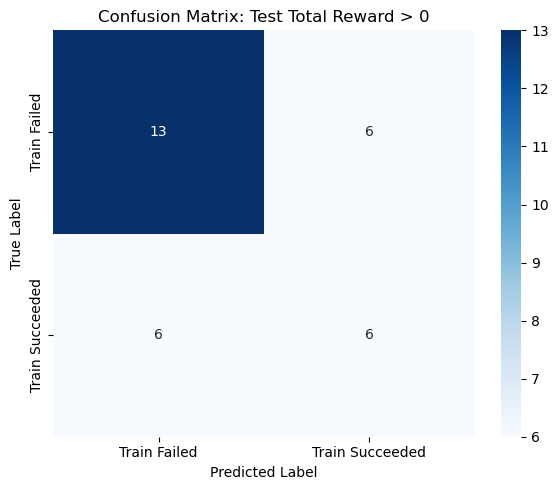

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Provided confusion matrix

# Labels
labels = ["Train Failed", "Train Succeeded"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Test Total Reward > 0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
ccccccc

In [4]:
# Load and Prepare Data ================
ohlcv_df = OHLCV_DF.copy()


# Filter Tickers ======================
tickers = ohlcv_df['symbol'].unique()
tickers = tickers[~np.isin(tickers, excluded_tickers)]
tickers = ["AAPL"]  # Force test with AAPL
#tickers = TOP2_STOCK_BY_SECTOR
# Load and prepare trackers
ep_tracker    = EpisodeTracker()
env_tracker   = EnvironmentTracker()
agent_tracker = AgentTracker()

In [5]:
ep = ep_tracker.findEpisode("2025-01-01","AAPL",120,"both")
train_df = ep['train']['df']

env = env_tracker.findEnvironment(
    "v4",
    {"lookback":0,
     "scaling_strategy":"auto",
     "n_timesteps":120,
     "market_features":[ "close", "price_change", "volume_change"]},
    ticker="AAPL",
    start_idx=ep['train']['df_start_iloc']
)
agent = agent_tracker.findAgent('PPO','MlpPolicy',{})

{'lookback': 0, 'market_features': ['close', 'price_change', 'volume_change'], 'n_timesteps': 120, 'scaling_strategy': 'auto'} {'lookback': 0, 'scaling_strategy': 'auto', 'n_timesteps': 120, 'market_features': ['close', 'price_change', 'volume_change']}


In [6]:
ep['train']
model = agent["model"].boot(env['environment'])
model

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [7]:
model.learn(total_timesteps=10_000)
#env['environment'].reset()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | -0.293   |
| time/              |          |
|    fps             | 402      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | -0.229      |
| time/                   |             |
|    fps                  | 315         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002372034 |
|    clip_fraction        | 0.00415     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.69       |
|    explained_variance   | -0.127      |
|    learning_rate        | 0.

In [8]:
env

{'env_id': 20,
 'id': 20,
 'version': 'v4',
 'config': {'lookback': 0,
  'market_features': ['close', 'price_change', 'volume_change'],
  'n_timesteps': 120,
  'scaling_strategy': 'auto',
  'ticker': 'AAPL',
  'start_idx': 631},
 'environment': <environments.PositionTradingEnvV4 at 0x1cb5a8183d0>}

In [12]:
#runs = eb.run()
train_df = ep['train']['df']
eb.extract_agent_diagnostics(env['environment'],model)

{'train_total_reward': 1.8202407111407886,
 'train_wallet': 1.2584602988536078,
 'train_market': 1.2610675191320353,
 'train_resid_oracle_std': 0.16476348787873227,
 'train_resid_oracle_skew': 7.138216526573901,
 'train_resid_oracle_kurtosis': 71.64433935674872,
 'train_resid_oracle_acf1': -0.03901116252172751,
 'train_resid_oracle_mean': -6.761922913547766e-05,
 'train_resid_oracle_median': -0.0014354248416223033,
 'train_resid_oracle_max': 1.5933017925434414,
 'train_resid_oracle_min': -0.4090312514457644,
 'train_ljung_oracle_pval': 0.45420327008791606,
 'train_resid_market_std': 0.026237528061081775,
 'train_resid_market_skew': 0.9599923971973492,
 'train_resid_market_kurtosis': 0.13234079430412038,
 'train_resid_market_acf1': 0.9456869757225531,
 'train_resid_market_mean': -0.03338358114565955,
 'train_resid_market_median': -0.0454075999595851,
 'train_resid_market_max': 0.041945170977429,
 'train_resid_market_min': -0.09230982611006544,
 'train_ljung_market_pval': 5.1406319857068

In [13]:
"""
# V4 AutoScaler =================================

# V4 ============================================
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | -0.293   |
| time/              |          |
|    fps             | 368      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean          | -0.227       |
| time/                   |              |
|    fps                  | 375          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0039481735 |
|    clip_fraction        | 0.00503      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.69        |
|    explained_variance   | -0.107       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.146        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00425     |
|    value_loss           | 0.253        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | -0.0435     |
| time/                   |             |
|    fps                  | 344         |
|    iterations           | 3           |
|    time_elapsed         | 17          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.004291957 |
|    clip_fraction        | 0.00679     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | 0.169       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0454     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00449    |
|    value_loss           | 0.221       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 0.179       |
| time/                   |             |
|    fps                  | 353         |
|    iterations           | 4           |
|    time_elapsed         | 23          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008619598 |
|    clip_fraction        | 0.0177      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0335     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00589    |
|    value_loss           | 0.206       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean          | 0.386        |
| time/                   |              |
|    fps                  | 353          |
|    iterations           | 5            |
|    time_elapsed         | 28           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0033814711 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.679       |
|    explained_variance   | 0.103        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.68e-05     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00903     |
|    value_loss           | 0.169        |
------------------------------------------

{'train_total_reward': 1.8404246654035108,
 'train_wallet': 1.2311124381229703,
 'train_market': 1.2610675191320353,
 'train_resid_oracle_std': 0.1649787826127421,
 'train_resid_oracle_skew': 7.100542170671588,
 'train_resid_oracle_kurtosis': 71.28572593394061,
 'train_resid_oracle_acf1': -0.03614584193924006,
 'train_resid_oracle_mean': -6.761922913547766e-05,
 'train_resid_oracle_median': -0.0005808469933746441,
 'train_resid_oracle_max': 1.5933017925434414,
 'train_resid_oracle_min': -0.4090312514457644,
 'train_ljung_oracle_pval': 0.43397976725966475,
 'train_resid_market_std': 0.004207810947213421,
 'train_resid_market_skew': 3.914946935632663,
 'train_resid_market_kurtosis': 19.557611931096172,
 'train_resid_market_acf1': 0.6085714183637173,
 'train_resid_market_mean': -0.004342682837053663,
 'train_resid_market_median': -0.006046241177076084,
 'train_resid_market_max': 0.022354143814353078,
 'train_resid_market_min': -0.006476324087659302,
 'train_ljung_market_pval': 4.222512971005281e-58,
 'train_sharpe': 0.09010650230498658,
 'train_sortino': 0.32005405023559785,
 'train_calmar': 1.8007265566029227,
 'train_market_sharpe': 0.09126171812151522,
 'train_market_sortino': 0.32781071367581516,
 'train_market_calmar': 1.8345812189354533}
<stable_baselines3.ppo.ppo.PPO at 0x18822e54a90>
"""

"\n---------------------------------\n| rollout/           |          |\n|    ep_len_mean     | 119      |\n|    ep_rew_mean     | -0.293   |\n| time/              |          |\n|    fps             | 368      |\n|    iterations      | 1        |\n|    time_elapsed    | 5        |\n|    total_timesteps | 2048     |\n---------------------------------\n------------------------------------------\n| rollout/                |              |\n|    ep_len_mean          | 119          |\n|    ep_rew_mean          | -0.227       |\n| time/                   |              |\n|    fps                  | 375          |\n|    iterations           | 2            |\n|    time_elapsed         | 10           |\n|    total_timesteps      | 4096         |\n| train/                  |              |\n|    approx_kl            | 0.0039481735 |\n|    clip_fraction        | 0.00503      |\n|    clip_range           | 0.2          |\n|    entropy_loss         | -0.69        |\n|    explained_variance   | -0.

In [14]:
xxxx

NameError: name 'xxxx' is not defined

In [ ]:
pddf= pd.DataFrame(runs)
pddf['train_episode_id'],pddf['test_episode_id']

In [ ]:
cols_to_drop = [col for col in pddf.columns if col.startswith('test_') and col != 'test_total_reward']
pddf_cleaned = pddf.drop(columns=cols_to_drop)

# Now you can compute correlation
correlations = pddf_cleaned.corr(numeric_only=True)['test_total_reward'].sort_values(ascending=False)
correlations

In [ ]:
pddf[['train_wallet','test_wallet','train_market','test_market','test_total_reward',"train_total_reward",
"train_sortino"                  ,
"train_calmar"                   ,
"train_resid_market_acf1"        ,
"train_resid_oracle_kurtosis"    ,
"train_sharpe"                   ,
"train_resid_oracle_max"         ]]

In [ ]:
ppdf['train_episode_id']